# 1D wave equation, finite difference, SciPy integration
_Gilbert François Duivesteijn_

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
from scipy.linalg import kron
from scipy.integrate import odeint

from matplotlib.animation import FuncAnimation
from IPython import display

np.set_printoptions(precision=4)

We write the wave equation as

\begin{align}
\frac{\partial^2 u}{\partial t^2} &= c^2\frac{\partial^2 u}{\partial x^2}  \qquad for -\infty < x < \infty
\end{align}

written with the subscript notation, the formula is written as

\begin{align}
u_{tt} = c^2 u_{xx} \qquad for -\infty < x < \infty
\end{align}

Following the writing of _Numerical Methods for PDE, MIT 2016_, we can define:

\begin{align}
\phi &= \frac{\partial u}{\partial t} \\
\psi &= \frac{\partial u}{\partial x} \\
\frac{\partial \psi}{\partial t} &= \frac{\partial^2 u}{\partial x \partial t} = \frac{\partial \phi}{\partial x}   \label{eq:sys1} \\
\frac{\partial^2 u}{\partial t^2} \equiv \frac{\partial \phi}{\partial t} &= \frac{\partial^2 u}{\partial x^2} \equiv \frac{\partial \psi}{\partial x}  \label{eq:sys2} \\
\end{align}

Writing down (\ref{eq:sys1}) and (\ref{eq:sys2}) in a system of equations results in

\begin{equation}
\left\{
\begin{array}{rcr}
\frac{\partial \psi}{\partial t} & = & \frac{\partial \phi}{\partial x} \\
\frac{\partial \phi}{\partial t} & = & \frac{\partial \psi}{\partial x}
\end{array}
\right.
\end{equation}

We will use central discretization for the spacial domain:

\begin{align}
\frac{\partial \phi}{\partial x} &= \frac{\phi_{i+1} - \phi_{i-1}}{2\Delta x} \\
\frac{\partial \psi}{\partial x} &= \frac{\psi_{i+1} - \psi_{i-1}}{2\Delta x}
\end{align}


Let's put it all together in one matrix:

\begin{align}
\begin{bmatrix}
\psi_t \\
\phi_t
\end{bmatrix} &= 
\begin{bmatrix}
A_{\phi} & 0 \\
0 & A_{\psi}
\end{bmatrix}
\begin{bmatrix}
\phi \\
\psi
\end{bmatrix}
\end{align}

In [3]:
# Constant U
c = 1

# Spacial domain
n = 200
L = 2*np.pi
dx = L / n
x = np.linspace(0, L, n)

# Time steps
T0 = 0
Tn = 2*np.pi
t_steps = 200
t = np.linspace(T0, Tn, t_steps)

# Initial condition, a bump in the middle of the domain.
phi_init = np.sin(x/2)**16      # velocity
psi_init = 0*phi_init           # displacement

phi_psi_init = np.hstack([phi_init, psi_init])

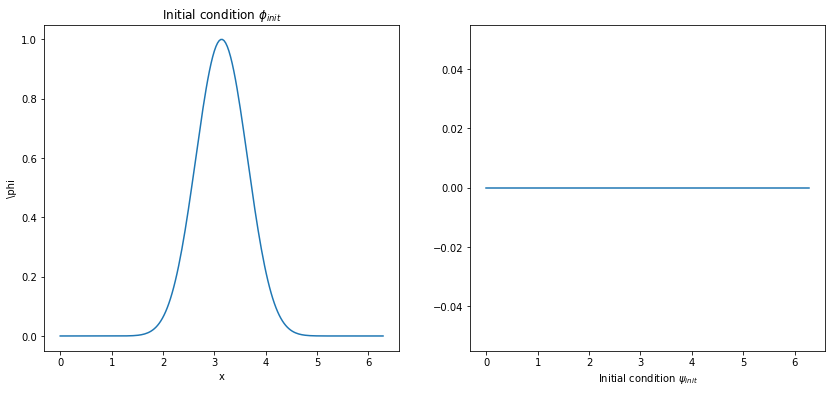

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(x, phi_init)
axs[0].set_xlabel("x")
axs[0].set_ylabel("\phi")
axs[0].set_title("Initial condition $\phi_{init}$")
axs[1].plot(x, psi_init)
axs[1].set_xlabel("x")
axs[1].set_xlabel("\psi")
axs[1].set_xlabel("Initial condition $\psi_{init}$")
plt.show()


In [5]:
A_phi = np.zeros(n)
A_phi = A_phi + np.diag( 1/(2*dx)*np.ones(n-1,),  1)
A_phi = A_phi + np.diag(-1/(2*dx)*np.ones(n-1,), -1)

# Cyclic boundary conditions: phi_{-1} = phi_{n-1}
A_phi[0,n-1] = -1/(2*dx)
A_phi[n-1, 0] = 1/(2*dx)

A_psi = np.zeros(n)
A_psi = A_psi + np.diag( 1/(2*dx)*np.ones(n-1,),  1)
A_psi = A_psi + np.diag(-1/(2*dx)*np.ones(n-1,), -1)

# Cyclic boundary conditions: psi_{-1} = psi_{n-1}
A_psi[0,n-1] = -1/(2*dx)
A_psi[n-1, 0] = 1/(2*dx)

# Combine A_phi and A_psi into one matrix
A = np.zeros(shape=(2*n,2*n))
A[:n, :n] = A_phi
A[n:, n:] = A_psi

In [6]:
def ddt(phi_psi, t, A, n):
    ddx =  np.matmul(A, phi_psi)
    dphidx = ddx[:n]
    dpsidx = ddx[n:]
    dpsidt = dphidx
    dphidt = dpsidx
    return np.hstack([dphidt, dpsidt])
    

In [7]:
phi_psi = odeint(ddt, phi_psi_init, t, args=(A, n))

In [8]:
phi_psi.shape
phi = phi_psi[:,:n]
psi = phi_psi[:,n:]

print(phi.shape, psi.shape)

(200, 200) (200, 200)


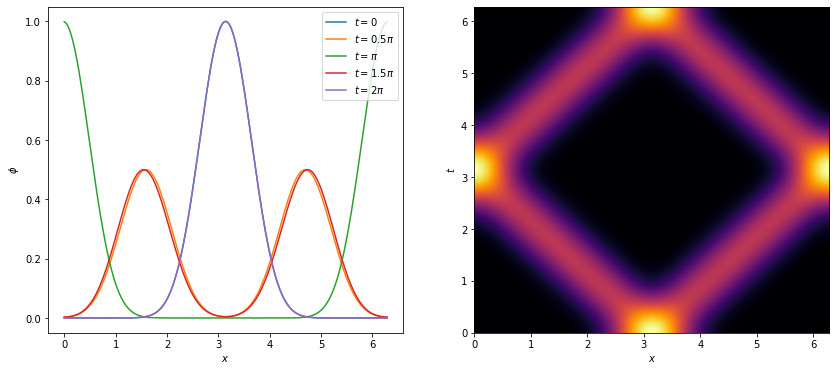

In [9]:
# plot phi

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(x, phi[0], label="$t=0$")
axs[0].plot(x, phi[49], label="$t=0.5\pi$")
axs[0].plot(x, phi[99], label="$t=\pi$")
axs[0].plot(x, phi[149], label="$t=1.5\pi$")
axs[0].plot(x, phi[199], label="$t=2\pi$")
axs[0].legend()
axs[0].set_ylabel("$\phi$")
axs[0].set_xlabel("$x$")
axs[1].imshow(phi, aspect="auto", cmap="inferno", extent=[0, L, T0, Tn], origin="lower")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$t$")
plt.show()

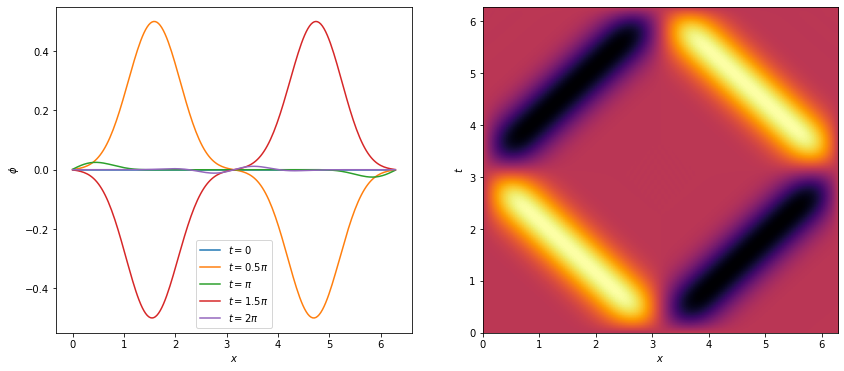

In [10]:
# plot psi

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs[0].plot(x, psi[0], label="$t=0$")
axs[0].plot(x, psi[49], label="$t=0.5\pi$")
axs[0].plot(x, psi[99], label="$t=\pi$")
axs[0].plot(x, psi[149], label="$t=1.5\pi$")
axs[0].plot(x, psi[199], label="$t=2\pi$")
axs[0].legend()
axs[0].set_ylabel("$\phi$")
axs[0].set_xlabel("$x$")
axs[1].imshow(psi, aspect="auto", cmap="inferno", extent=[0, L, T0, Tn], origin="lower")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$t$")
plt.show()

In [11]:
# Animation of the solution over the integrated time span.

def animate(frame):
    y = phi[frame]
    line_phi.set_data((x, phi[frame]))
    line_psi.set_data((x, psi[frame]))
    plt.title(f"t={Tn * frame / t_steps:0.2f}")

    
fig = plt.figure(figsize=(12,6))
line_phi = plt.plot([])[0]
line_psi = plt.plot([])[0]
plt.xlim([0, L])
plt.ylim([-1, 1])
plt.xlabel("x")
plt.ylabel("phi / psi")
plt.title("")
  
anim = FuncAnimation(fig, animate, frames=t_steps, interval=50)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()